In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Dataset import *
from Metric import *
from Model import *
from Preprocess import *
from train import *
from tqdm.auto import trange
import torch.nn.functional as F
from config import config

/home/jihye/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = pd.read_csv("data/final.csv")
data['YearMonth'] = pd.to_datetime(data['YearMonth'])
data.set_index('YearMonth', inplace=True)
tst_size=20
trn, tst = data[:-tst_size], data[-tst_size:]

In [3]:
multiparams = config['Multi']['model_params']
multi_lookback_size = multiparams['multi_lookback_size']
multi_forecast_size = multiparams['multi_forcast_size']
multi_batch_size = multiparams['multi_batch_size']
multi_channel_size = multiparams['multi_channel_size']
multi_hidden_size = multiparams['multi_hidden_size']

In [4]:
multimodel = NetMulti(multi_lookback_size,multi_forecast_size,multi_hidden_size,multi_channel_size)
multimodel.load_state_dict(torch.load("_4channel_Adam_300_lookback80_forecast20_multichannel_dict.pth"))
multimodel.eval()

NetMulti(
  (lin1): Linear(in_features=320, out_features=512, bias=True)
  (lin2): Linear(in_features=512, out_features=512, bias=True)
  (lin3): Linear(in_features=512, out_features=80, bias=True)
)

In [5]:
data['rolling_mean'] = data['Temperature'].rolling(12).mean()


#3채널일땐 아랫줄 주석
data['rolling_mean2'] = data['Temperature'].rolling(4).mean()


data['diff1'] = data['Temperature'].diff(1)
m2_data = data.dropna()

multidata = MultiANNLoadData(m2_data,multi_lookback_size,multi_forecast_size,tst_size,multi_batch_size)
multi_trn_dl, multi_tst_dl , multi_trn_ds = multidata.scaling()

## 단기

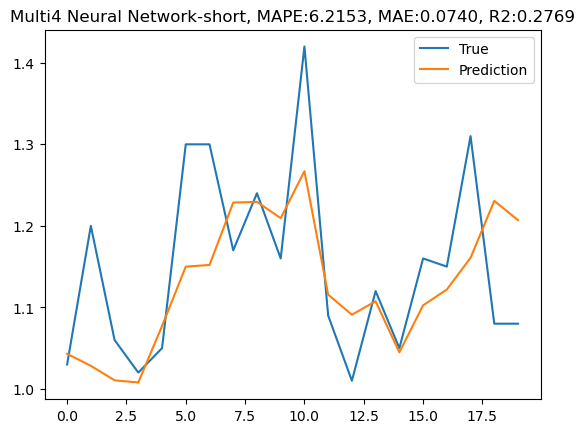

In [6]:
scaler3 = multidata.get_scaler()

multimodel.eval()
multimodel.to('cuda')
with torch.inference_mode():
  x, y = next(iter(multi_tst_dl))
  y=y.reshape(-1,multi_channel_size)
  y=scaler3.inverse_transform(y.cpu().numpy())
  y=y.reshape(-1,multi_forecast_size,multi_channel_size)
  x, y = x.flatten(1), y[:,:,0] #17,4    0번째 채널을 뽑고있다.
  #print(x)
  x = x.to('cuda')
  p = multimodel(x)
  #print(p)
  p = p.reshape(-1,multi_channel_size)
  p=p.cpu()
  p=scaler3.inverse_transform(p.numpy())
  p = p.reshape(-1,multi_forecast_size,multi_channel_size)

y = np.concatenate([y[:,0], y[-1,1:]])
p = np.concatenate([p[:,0], p[-1,1:]])
p = p[:,0]


plt.title(f"Multi{multi_channel_size} Neural Network-short, MAPE:{mape(p,y):.4f}, MAE:{mae(p,y):.4f}, R2:{r2_score(p,y):.4f}")
plt.plot(range(tst_size), y, label="True")
plt.plot(range(tst_size), p, label="Prediction")
plt.legend()
plt.show()

## 장기

(20,)


<Axes: title={'center': 'Multi4_ANN_long, MAPE:7.4888, MAE:0.0870, R2:0.026066423145628348'}, xlabel='YearMonth'>

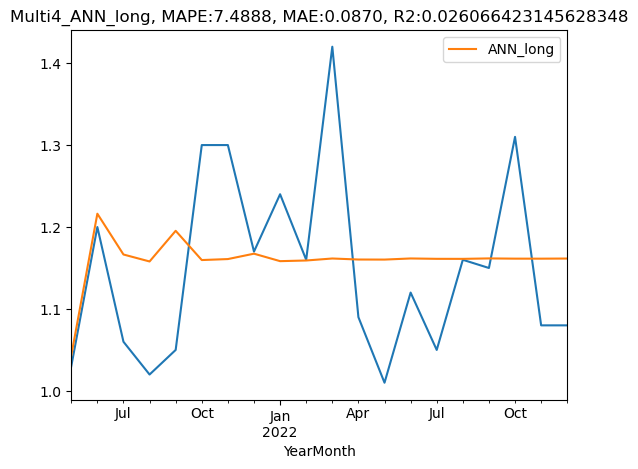

In [7]:
multimodel.eval()
window_size = multi_lookback_size
prediction_size = multi_forecast_size
preds = []
multimodel.to(device)

x2, y2 = multi_trn_ds[len(multi_trn_ds)-1]
preds = []

for i in range(tst_size):
  y2 = y2.squeeze()
  x2 = np.concatenate([x2,y2])[-window_size:]
  #print(x)
  x_tensor = torch.tensor(x2, dtype=torch.float32).unsqueeze(0).to(device)
  y2 = multimodel(x_tensor)
  y2 = y2.detach().cpu().numpy()
  preds.append(y2)

preds = np.concatenate(preds, axis=0)
inverse_preds = scaler3.inverse_transform(preds.reshape(-1,multi_channel_size)).reshape(-1,multi_forecast_size,multi_channel_size)

final_preds = inverse_preds[:, 0,0]
print(final_preds.shape)

# 장기예측 plot
trn, tst = data.Temperature[:-tst_size], data.Temperature[-tst_size:]
plt.title(f"Multi{multi_channel_size}_ANN_long, MAPE:{mape(final_preds,data.Temperature[-tst_size:].to_numpy()):.4f}, MAE:{mae(final_preds,data.Temperature[-tst_size:].to_numpy()):.4f}, R2:{r2_score(final_preds,data.Temperature[-tst_size:].to_numpy())}")
df = pd.DataFrame({"ANN_long": final_preds}, index=tst.index)
ax = tst.plot(label="TRUE")
df.plot(ax=ax)

## 통으로

MAPE:  6.2153449420724
MAE:  0.07398716378211975
R2_Score:  0.276897768558813


<Axes: xlabel='YearMonth'>

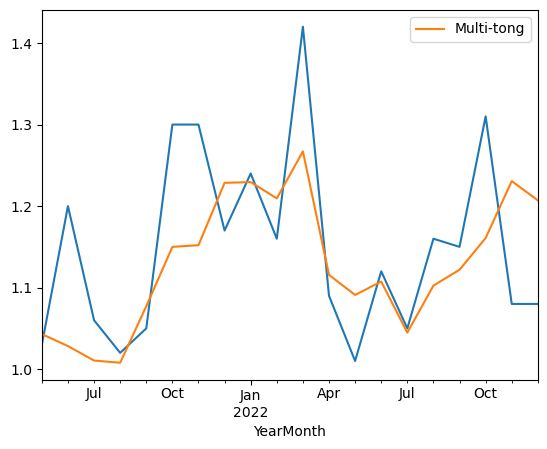

In [8]:
multimodel.eval()
a, b = multi_trn_ds[len(multi_trn_ds)-1]
x2 = np.concatenate([a,b])[-window_size:]
multi_tensor = torch.tensor(x2, dtype=torch.float32).unsqueeze(0).to(device)
multiy = multimodel(multi_tensor)
multiy = multiy.detach().cpu().numpy()
multiy = multiy.reshape(multi_forecast_size,multi_channel_size)
multiy = scaler3.inverse_transform(multiy).squeeze()

mape2 = mape(multiy[:,0],data.Temperature[-tst_size:].to_numpy())
print("MAPE: ",mape2)
mae2 = mae(multiy[:,0],data.Temperature[-tst_size:].to_numpy())
print("MAE: ",mae2)
r2_score2 = r2_score(multiy[:,0],data.Temperature[-tst_size:].to_numpy())
print("R2_Score: ", r2_score2)

#plt.title(f"PatchTST (extended dataset), MAPE:{mape(preds,data.Temperature[-20:].to_numpy()):.4f}, MAE:{mae(preds,data.Temperature[-20:].to_numpy()):.4f}, R2:{r2_score(preds,data.Temperature[-20:].to_numpy())(p,y):.4f}")
df = pd.DataFrame({"Multi-tong": multiy[:,0]}, index=tst.index)

trn, tst = data.Temperature[:-tst_size], data.Temperature[-tst_size:]
ax = tst.plot(label="TRUE")
df.plot(ax=ax)